In [344]:
import os
GOOGLE_APPLICATION_CREDENTIALS = "/Users/zacharynguyen/Documents/GitHub/2024/Applied-Generative-AI/IAM/zacharynguyen-genai-656c475b142a.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_APPLICATION_CREDENTIALS

In [345]:
PROJECT_ID = 'zacharynguyen-genai' # replace with project ID
os.environ["PROJECT_ID"] = PROJECT_ID

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [346]:
#!pip install -r requirements.txt 


### API Enablement

In [347]:
#!gcloud auth login

In [348]:
#!gcloud services enable aiplatform.googleapis.com
#!gcloud services enable documentai.googleapis.com

---
## Setup

Inputs

In [349]:
project = !gcloud config get-value project
project[1]


'zacharynguyen-genai'

In [350]:
PROJECT_ID='zacharynguyen-genai'
REGION = 'us-central1'
EXPERIMENT = '2024-HCA-Benefit-Brochure'
SERIES = 'applied-genai-v3'

# save results in: GCS, BQ, ALL
SAVE_IN = 'ALL'
# retrieve results from: GCS, BQ.  If not present then it will run parsing and embedding.
RETRIEVE_FROM = 'GCS'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2]

# location for the source documents (PDF): can be http:// or gs://, a list of one or more document links
source_documents = ['https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf']

# If a prior run is available then:
# a value of True will trigger loading it from RETRIEVE_FROM,
# a value of False will trigger removing (if exist) from all possible sources.  This forces a regeneration when needed.
USE_PRIOR_RUN = True

# first question to ask
question = "How 401(k) Matching Works?"

Packages

In [351]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time
import asyncio

import PyPDF2
import IPython
import PIL, PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import vertexai.language_models # PaLM and Codey Models
import vertexai.generative_models # for Gemini Models
from google.cloud import documentai
from google.cloud import storage
from google.cloud import bigquery
from google.api_core import retry

### Create GCS Bucket

In [352]:
def create_gcs_bucket(project_id, bucket_name, region):
    storage_client = storage.Client(project=project_id)
    bucket = storage_client.bucket(bucket_name)
    new_bucket = storage_client.create_bucket(bucket, location=region)
    print(f"Bucket {new_bucket.name} created.")
    return new_bucket

In [353]:
# Create GCS Bucket
#create_gcs_bucket(PROJECT_ID, GCS_BUCKET, REGION)

### Create dataset and table in BigQuery

In [354]:
def create_bq_dataset_and_table(project_id, dataset_id, table_id, region):
    """
    Creates a new dataset and table in BigQuery.

    Parameters:
    - project_id: Your GCP project ID.
    - dataset_id: The ID of the dataset to create.
    - table_id: The ID of the table to create within the dataset.
    - region: The region where the dataset will be located.

    Returns:
    - Table: The created BigQuery table object.
    """
    bq_client = bigquery.Client(project=project_id)

    # Create the dataset
    dataset_ref = bigquery.DatasetReference(project_id, dataset_id)
    dataset = bigquery.Dataset(dataset_ref)
    dataset.location = region
    created_dataset = bq_client.create_dataset(dataset, exists_ok=True)
    print(f"Dataset {created_dataset.dataset_id} created in project {project_id}.")

    # Create the table
    schema = [
        bigquery.SchemaField("example_field", "STRING", mode="NULLABLE")
    ]
    table_ref = dataset_ref.table(table_id)
    table = bigquery.Table(table_ref, schema=schema)
    created_table = bq_client.create_table(table, exists_ok=True)
    print(f"Table {created_table.table_id} created in dataset {created_dataset.dataset_id}.")

    return created_table

In [355]:

# Create BigQuery Dataset and Table
#create_bq_dataset_and_table(PROJECT_ID, BQ_DATASET, BQ_TABLE, BQ_REGION)

Clients

In [356]:
from google.cloud import documentai, bigquery, storage
import vertexai

# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=REGION)

# Setup Document AI clients
LOCATION = REGION.split('-')[0]
docai_endpoint = f"{LOCATION}-documentai.googleapis.com"
docai_client_options = {"api_endpoint": docai_endpoint}

# Document AI synchronous client
docai_client = documentai.DocumentProcessorServiceClient(client_options=docai_client_options)

# Document AI asynchronous client
docai_async_client = documentai.DocumentProcessorServiceAsyncClient(client_options=docai_client_options)

# Initialize BigQuery client
bq = bigquery.Client(project=PROJECT_ID)

# Initialize Google Cloud Storage (GCS) client and get the bucket
gcs = storage.Client(project=PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

# Print confirmation that clients have been initialized successfully
print("Initialized Vertex AI, Document AI, BigQuery, and GCS clients successfully.")


Initialized Vertex AI, Document AI, BigQuery, and GCS clients successfully.


---
## Vertex LLM Setup

> For a detailed overview of all the genative AI models and their APIs check out the companion notebook: [Getting Started - Vertex AI GenAI Python Client](./Getting%20Started%20-%20Vertex%20AI%20GenAI%20Python%20Client.ipynb)

With the [vertexai](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai) client there are packages for the types of data being interacted with.  There is also a higher package for preview models (not yet in GA).

> **NOTE:** In can be helpful to review the API Documentation at it's source in GitHub for up to the moment release information: [github/googleapis/python-aiplatform](https://github.com/googleapis/python-aiplatform/tree/main)

Gemini Text and Multimodal Models:
- [vertexai.generative_models()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.generative_models)
    - [vertexai.preview.generative_models()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.generative_models)

Language Models (PaLM and Codey Models):
- [vertexai.language_models()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models)
    - [vertexai.preview.language_models()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models)

In [357]:
# Gemini Models
gemini_text = vertexai.generative_models.GenerativeModel("gemini-1.0-pro")

# PaLM Models
textembed_model = vertexai.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko')
text_model_b = vertexai.language_models.TextGenerationModel.from_pretrained('text-bison')
text_model_b32 = vertexai.language_models.TextGenerationModel.from_pretrained('text-bison-32k')
text_model_u = vertexai.language_models.TextGenerationModel.from_pretrained('text-unicorn')

### Prompt

In [358]:
question

'How 401(k) Matching Works?'

### Embeddings

In [359]:
textembed_model.get_embeddings([question])[0].values[0:5]

[0.05706017464399338,
 -0.04649510979652405,
 -0.03461793437600136,
 -0.021292798221111298,
 -0.020159518346190453]

### Generation: PaLM `text-bison`

In [360]:
response = text_model_b.predict(question)
response

 A 401(k) match is a contribution that your employer makes to your 401(k) retirement savings plan on your behalf. It's a way for your employer to help you save for retirement and it can be a great way to boost your savings.

Here's how 401(k) matching works:

1. **Your employer sets a match percentage.** This is the percentage of your salary that your employer will contribute to your 401(k) plan. For example, your employer may offer a 50% match, which means that they will contribute 

In [361]:
response.safety_attributes

{'Derogatory': 0.1,
 'Finance': 1.0,
 'Health': 0.2,
 'Insult': 0.2,
 'Religion & Belief': 0.4,
 'Sexual': 0.1}

In [362]:
response = text_model_b.predict(question, max_output_tokens = 500)
response

 A 401(k) match is a contribution that your employer makes to your 401(k) retirement savings plan on your behalf. It's a way for your employer to help you save for retirement and it can be a great way to boost your savings.

Here's how 401(k) matching works:

1. **Your employer sets a match percentage.** This is the percentage of your salary that your employer will contribute to your 401(k) plan. For example, your employer may offer a 50% match, which means that they will contribute 50 cents for every dollar that you contribute.
2. **You contribute to your 401(k) plan.** You can contribute up to $22,500 to your 401(k) plan in 2023 ($30,000 if you're age 50 or older).
3. **Your employer makes a matching contribution.** Your employer will make a matching contribution to your 401(k) plan based on the match percentage that they've set. For example, if you contribute $1,000 to your 401(k) plan and your employer offers a 50% match, they will contribute $500 to your plan.

401(k) matching is 

In [363]:
IPython.display.Markdown(response.text)

 A 401(k) match is a contribution that your employer makes to your 401(k) retirement savings plan on your behalf. It's a way for your employer to help you save for retirement and it can be a great way to boost your savings.

Here's how 401(k) matching works:

1. **Your employer sets a match percentage.** This is the percentage of your salary that your employer will contribute to your 401(k) plan. For example, your employer may offer a 50% match, which means that they will contribute 50 cents for every dollar that you contribute.
2. **You contribute to your 401(k) plan.** You can contribute up to $22,500 to your 401(k) plan in 2023 ($30,000 if you're age 50 or older).
3. **Your employer makes a matching contribution.** Your employer will make a matching contribution to your 401(k) plan based on the match percentage that they've set. For example, if you contribute $1,000 to your 401(k) plan and your employer offers a 50% match, they will contribute $500 to your plan.

401(k) matching is a great way to save for retirement. It's free money from your employer, and it can help you reach your retirement savings goals faster. If your employer offers a 401(k) match, be sure to take advantage of it.

Here are some additional things to keep in mind about 401(k) matching:

* **The match percentage may be based on your salary or your contributions.** Some employers match a percentage of your salary, while others match a percentage of your contributions.
* **There may be a vesting schedule.** A vesting schedule is a period of time that you must work for your employer before you become fully entitled to the matching contributions. For example, you may have to work for your employer for five years before you become fully vested in the matching contributions.
* **The match may be subject to tax withholding.** The matching contributions that your employer makes to your 401(k) plan may be subject to tax withholding. This means that the money will be

### Generation: PaLM `text-unicorn`

In [364]:
response = text_model_u.predict(question)
response

A 401(k) match is a contribution that your employer makes to your 401(k) account. The amount of the match is typically based on a percentage of your salary, and it is often subject to a vesting schedule.

Here is how 401(k) matching works:

1. You make contributions to your 401(k) account.
2. Your employer matches a percentage of your contributions.
3. The matched contributions are deposited into your 401(k) account.
4. The matched contributions are subject to a 

In [365]:
IPython.display.Markdown(response.text)

A 401(k) match is a contribution that your employer makes to your 401(k) account. The amount of the match is typically based on a percentage of your salary, and it is often subject to a vesting schedule.

Here is how 401(k) matching works:

1. You make contributions to your 401(k) account.
2. Your employer matches a percentage of your contributions.
3. The matched contributions are deposited into your 401(k) account.
4. The matched contributions are subject to a 

### Generation: PaLM `text-bison-32k`

In [366]:
response = text_model_b32.predict(question)
response

 A 401(k) match is a contribution that your employer makes to your 401(k) retirement savings plan on your behalf. It's a way for your employer to help you save for retirement and it can be a great way to boost your savings.

Here's how 401(k) matching works:

1. **You contribute money to your 401(k) plan from your paycheck.**
2. **Your employer matches your contribution up to a certain percentage.** The percentage match can vary from employer to employer, but it's typically between 3%

In [367]:
IPython.display.Markdown(response.text)

 A 401(k) match is a contribution that your employer makes to your 401(k) retirement savings plan on your behalf. It's a way for your employer to help you save for retirement and it can be a great way to boost your savings.

Here's how 401(k) matching works:

1. **You contribute money to your 401(k) plan from your paycheck.**
2. **Your employer matches your contribution up to a certain percentage.** The percentage match can vary from employer to employer, but it's typically between 3%

### Generation: Gemini `gemini-1.0-pro`

In [368]:
response = gemini_text.generate_content(question)
response

candidates {
  content {
    role: "model"
    parts {
      text: "**401(k) Matching**\n\n401(k) matching is a benefit some employers offer where they contribute a specified amount of money to an employee\'s 401(k) plan for each dollar the employee contributes.\n\n**How It Works:**\n\n1. **Employee Contribution:** An employee elects to contribute a percentage of their pre-tax salary to their 401(k) plan through payroll deductions.\n2. **Employer Match:** The employer then matches a portion of the employee\'s contribution up to a specified limit. Typically, this match is a dollar-for-dollar or proportional contribution. For example, the employer may match 50% or 100% of the employee\'s contribution up to a maximum of 6%.\n3. **Employer\'s Contribution:** The matched funds are deposited directly into the employee\'s 401(k) account. These funds are tax-deductible for the employer.\n\n**Example:**\n\nIf an employee contributes $200 to their 401(k) with a 50% employer match, the employer w

In [369]:
print(response.text)

**401(k) Matching**

401(k) matching is a benefit some employers offer where they contribute a specified amount of money to an employee's 401(k) plan for each dollar the employee contributes.

**How It Works:**

1. **Employee Contribution:** An employee elects to contribute a percentage of their pre-tax salary to their 401(k) plan through payroll deductions.
2. **Employer Match:** The employer then matches a portion of the employee's contribution up to a specified limit. Typically, this match is a dollar-for-dollar or proportional contribution. For example, the employer may match 50% or 100% of the employee's contribution up to a maximum of 6%.
3. **Employer's Contribution:** The matched funds are deposited directly into the employee's 401(k) account. These funds are tax-deductible for the employer.

**Example:**

If an employee contributes $200 to their 401(k) with a 50% employer match, the employer will add an additional $100 to the employee's account. The employee's total contributi

In [370]:
IPython.display.Markdown(response.text)

**401(k) Matching**

401(k) matching is a benefit some employers offer where they contribute a specified amount of money to an employee's 401(k) plan for each dollar the employee contributes.

**How It Works:**

1. **Employee Contribution:** An employee elects to contribute a percentage of their pre-tax salary to their 401(k) plan through payroll deductions.
2. **Employer Match:** The employer then matches a portion of the employee's contribution up to a specified limit. Typically, this match is a dollar-for-dollar or proportional contribution. For example, the employer may match 50% or 100% of the employee's contribution up to a maximum of 6%.
3. **Employer's Contribution:** The matched funds are deposited directly into the employee's 401(k) account. These funds are tax-deductible for the employer.

**Example:**

If an employee contributes $200 to their 401(k) with a 50% employer match, the employer will add an additional $100 to the employee's account. The employee's total contribution for the month is $300.

**Benefits of 401(k) Matching:**

* **Enhanced Retirement Savings:** By providing matching funds, employers help employees save more for retirement.
* **Investment Incentives:** The matching contributions can motivate employees to save a higher percentage of their income.
* **Tax Benefits:** Both the employee's and employer's contributions grow tax-deferred, allowing for potential long-term growth.
* **Employee Retention:** 401(k) matching can incentivize employees to stay with the company and encourage loyalty.

**Matching Limits:**

The Internal Revenue Service (IRS) sets limits on the amount of money an employer can contribute to an employee's 401(k) plan. In 2023, the contribution limit for employees is $22,500, and the combined limit for employee and employer contributions is $66,000.

**Matching Vesting:**

In some cases, the employer's matching contributions may be subject to vesting requirements. This means that the employee may need to work for a certain period before they have full ownership of the employer-contributed funds.

---
## Retrieve Files From Previous Run on GCS Or BigQuery

This uses the input parameter set above: `RETRIEVE_FROM`.  If it is set to `BQ` or `GCS` then it will check the source for an available prior run and retrieve it if it exists.


Function to check for existance of BigQuery Table:

In [371]:
def bq_table_check(table):
    from google.cloud.exceptions import NotFound
    try:
        bq.get_table(table)
        return True
    except NotFound:
        return False
    
bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'), bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages_chunks')

(False, False)

In [372]:
if USE_PRIOR_RUN == False:
    PRIOR_PARSE = False
    
    # do a check for prior run and present message if found letting user know the prior result exists but not being used
    if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
        print(f'Previous results exists in GCS but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
    elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
        print(f'Previous results exists in BQ but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')

elif RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
    print('Importing previous run from GCS')

    # load files_pages: the file+page level information including docai responses in `parsing`
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
    files_pages = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load files_pages_chunks: the chunks parsed from the files+pages
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_chunks.json')
    files_pages_chunks = [json.loads(line) for line in blob.download_as_text().splitlines()]   
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True

elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
    print('Importing previous run from BigQuery')

    # load files_pages: the file+page level information including docai responses in `parsing`
    files_pages = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages` ORDER BY file_index, page_index').to_dataframe().to_dict('records')
    # convert json string to dictionary:
    for page in files_pages:
        page['parsing'] = json.loads(page['parsing'])
    
    # load files_pages_chunks: the chunks parsed from the files+pages
    files_pages_chunks = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages_chunks`').to_dataframe().to_dict('records')
    #convert json string to dictionary:
    for chunk in files_pages_chunks:
        chunk['metadata'] = json.loads(chunk['metadata'])
    # sort chunk by file, page, chunk number:
    files_pages_chunks = sorted(files_pages_chunks, key = lambda x: (x['metadata']['file_index'], x['metadata']['page_index'], x['metadata']['chunk']))

    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
        
else:
    print('No previous run available to import')
    PRIOR_PARSE = False

No previous run available to import


---
## Get/Create Document AI Processors

Document AI is comprised of multiple processors.  In this case the Form parser is used for its ability to detect and extract tables as well as OCR.  For a more thorough review of Document AI processors, including customized parsers, see the [Working With/Document AI](../Working%20With/Document%20AI/readme.md) section of this repository.  This repository includes example of processing document at larger scales and storing the data for processing and retrieval.

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors).

In [373]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.1-2023-06-26'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
    if p.display_name == PARSER_DISPLAY_NAME:
        parser = p
try:
    print('Retrieved existing parser: ', parser.name)
except Exception:
    parser = docai_client.create_processor(
        parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
        processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
    )
    print('Created New Parser: ', parser.name)

Retrieved existing parser:  projects/67031084133/locations/us/processors/ab4bd266099f2e0c


---
## Get The Documents

Get the source PDF(s) from GCS or a URL and store as a list of pages for each file: `file_pages`.

Get Location of Files

In [374]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    document_locations = []
    for source_document in source_documents:
        if source_document.startswith('http'):
            document_locations.append('URL')
            print(f'Use requests to get online document: {source_document}')
        elif source_document.startswith('gs'):
            document_locations.append('GCS')
            print(f'Use GCS to get document in GCS: {source_document}')
        else:
            document_locations.append('UNKNOWN')
            print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')

Use requests to get online document: https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf


Import the PDF to memory as bytes:

In [375]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    imported_documents = []
    for s, source_document in enumerate(source_documents):
        if document_locations[s] == 'URL':
            imported_documents.append(requests.get(source_document).content)
        elif document_locations[s] == 'GCS':
            blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
            imported_documents.append(blob.download_as_bytes())
        elif document_locations[s] == 'UNKNOWN':
            imported_documents.append(None)
    type(imported_documents[0])       

Convert from bytes to PDF:

In [376]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    converted_documents = []
    for imported_document in imported_documents:
        if imported_document:
            converted_documents.append(PyPDF2.PdfReader(io.BytesIO(imported_document)))
        else:
            converted_documents.append(None)
        type(converted_documents[0])    

Review number of pages per PDF:

In [377]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    for f, file in enumerate(converted_documents):
        if file:
            print(f"{source_documents[f]} has {len(file.pages)} pages")

https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf has 17 pages


Split PDF(s) to list of individual pages for each file:

List of dictionaries with keys: file_index, page_index, raw_file_page

In [378]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    # list of tuples (file index, page number, page content)
    files_pages = []
    for c, converted_document in enumerate(converted_documents):
        if converted_document:
            for page_num, page in enumerate(converted_document.pages, 1):
                writer = PyPDF2.PdfWriter()
                writer.add_page(page)
                with io.BytesIO() as bytes_stream:
                    files_pages.append(
                        dict(file_index = c, page_index = page_num, raw_file_page = writer.write(bytes_stream)[1].getbuffer().tobytes())
                    )
len(files_pages)

17

---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 requests per minute per project. The code below implements waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [379]:
async def docai_runner(files_pages, limit_concur_requests = 120):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    result = await docai_async_client.process_document(
                        request = dict(
                            raw_document = documentai.RawDocument(
                                content = files_pages[p]['raw_file_page'],
                                mime_type = 'application/pdf'
                            ),
                            name = parser.name
                        )
                    )
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = documentai.Document.to_dict(result.document)
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages))]
    responses = await asyncio.gather(*tasks)
    
    # add parsing to input list of dictionaries for all the pages
    for c, content in enumerate(files_pages):
        content['parsing'] = results[c]
    
    return

In [380]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    await docai_runner(files_pages)
    # remove the raw file page
    for page in files_pages: del page['raw_file_page']

No Prior Results, Parsing with Document AI


In [381]:
len(files_pages)

17

In [382]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [383]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'entities', 'text_styles', 'entity_relations', 'text_changes', 'revisions'])

For each pages dictionary, add the path, file, page, and embedding of the full full pages OCR results:

In [384]:
async def embedding_pages(files_pages, limit_concur_requests = 500):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    if files_pages[p]['parsing']['text']:
                        result = await textembed_model.get_embeddings_async([files_pages[p]['parsing']['text']])
                    else:
                        obj = lambda: None
                        obj.values = [None]
                        result = [obj]
                    
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = result[0].values
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages))]
    responses = await asyncio.gather(*tasks)
    
    for c, content in enumerate(files_pages):
        content['parsing']['embedding'] = results[c]
    
    return

In [385]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Using Document AI Parsing')
    await embedding_pages(files_pages)
    for c, content in enumerate(files_pages):
        document_image = PIL.Image.open(
            io.BytesIO(
                base64.decodebytes(content['parsing']['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
        content['parsing']['path'] = source_documents[content['file_index']][:(-1*len(source_documents[content['file_index']].split('/')[-1]))]
        content['parsing']['file'] = source_documents[content['file_index']].split('/')[-1]
        content['parsing']['page'] = content['page_index']
        content['parsing']['vme_id'] = f"{content['file_index']}_{content['page_index']}"
        content['parsing']['dimensions'] = list(document_image.size)
        if not content['parsing']['text']:
            content['parsing']['embedding'] = []

No Prior Results, Using Document AI Parsing


In [386]:
len(files_pages)

17

In [387]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [388]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'entities', 'text_styles', 'entity_relations', 'text_changes', 'revisions', 'embedding', 'path', 'file', 'page', 'vme_id', 'dimensions'])

### Parse Chunks From Documents

Elements to capture here are paragraphs and tables.  If a paragraph overlaps a table then include it within the table.

In [389]:
if PRIOR_PARSE:
    print('Using Prior Document Preparation')
else:
    files_pages_chunks = []
    
    for content in files_pages:
        page = content['parsing']
        chunk_id = 0
        
        # parse tables from page:
        tables = []
        for t, table in enumerate(page['pages'][0]['tables']):

            table_txt = ''
            if 'text_anchor' in table['layout'].keys():
                for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
                    if t == 0 and s == 0: start = 0
                    else: start = int(segment['start_index'])
                    end = int(segment['end_index'])
                    table_txt += page['text'][start:end+t]

            vertices = []
            normalized_vertices = []
            for vertex in table['layout']['bounding_poly']['normalized_vertices']:
                normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
            tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

            if table_txt != '':
                files_pages_chunks.append(
                    dict(
                        text = table_txt,
                        metadata = dict(
                            file_index = content['file_index'],
                            page_index = content['page_index'],
                            table = t + 1,
                            chunk = chunk_id + 1,
                            vme_id = page['vme_id'] + '_' + str(chunk_id),
                            vertices = vertices,
                            normalized_vertices = normalized_vertices
                        )
                    )
                )
                chunk_id += 1       
        
        # parse paragraphs from page - not in tables or overlapping tables
        for g, paragraph in enumerate(page['pages'][0]['paragraphs']):

            # get the paragraph text
            paragraph_txt = ''
            for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
                if g == 0 and s == 0: start = 0
                else: start = int(segment['start_index'])
                end = int(segment['end_index'])
                paragraph_txt += page['text'][start:end+1]

            # if paragraph not empty, get/calc the vertices
            if paragraph_txt != '':
                use_paragraph = True
                vertices = []
                normalized_vertices = []
                for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
                    normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                    vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
            else:
                use_paragraph = False

            # only use paragraphs that are not within/overlapping table boundaries
            if use_paragraph:
                for t_shape in tables:
                    p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
                    if p_shape.intersects(t_shape):
                        use_paragraph = False

            # save the paragraph as an element
            if use_paragraph:
                files_pages_chunks.append(
                    dict(
                        text = paragraph_txt,
                        metadata = dict(
                            file_index = content['file_index'],
                            page_index = content['page_index'],
                            paragraph = g + 1,
                            chunk = chunk_id +1,
                            vme_id = page['vme_id'] + '_' + str(chunk_id),
                            vertices = vertices,
                            normalized_vertices = normalized_vertices
                        )
                    )
                )
                chunk_id += 1        

In [390]:
len(files_pages_chunks)

358

In [391]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata'])

In [392]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

---
## Get Embeddings


The `textembedding-gecko` model has quota of 1500 request per minute:
- [Quotas by region and model](https://cloud.google.com/vertex-ai/generative-ai/docs/quotas#quotas_by_region_and_model)

In [393]:
async def embedding_runner(files_pages_chunks, limit_concur_requests = 500):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages_chunks)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    result = await textembed_model.get_embeddings_async([files_pages_chunks[p]['text']])
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = result[0].values
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages_chunks))]
    responses = await asyncio.gather(*tasks)
    
    # add embeddings to input list of dictionaries for all the chunks
    for c, content in enumerate(files_pages_chunks):
        content['embedding'] = results[c]
    
    await asyncio.sleep(60)
    
    return

In [394]:
if PRIOR_PARSE:
    print('Embeddings created on previous run.')
else:
    await embedding_runner(files_pages_chunks)

In [395]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [396]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

In [397]:
files_pages_chunks[0]['embedding'][0:5]

[0.03505541384220123,
 -0.014194360934197903,
 -0.00693921884521842,
 -0.047134727239608765,
 0.010355176404118538]

---
## Save Files For Future Runs: GCS, BigQuery

Use the values of the input parameter `SAVE_IN` to optionally write both `results` and `documents` to `BQ`, `GCS` or `ALL` (both).

It can take awhile to run the parsing job above so save results for future runs of this notebook.  Also, this prevents recurring cost of running the Document AI parsing of the documents.

In [398]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [399]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [400]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    if SAVE_IN in ['GCS', 'ALL']:
        print('Writing contents of results and documents to GCS for future use.')

        # save files_pages: json lines                    
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
        blob.upload_from_string('\n'.join([json.dumps(page) for page in files_pages]), content_type = 'application/json')

        # save files_pages_elements: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_chunks.json')
        blob.upload_from_string('\n'.join([json.dumps(chunk) for chunk in files_pages_chunks]), content_type = 'application/json')

    if SAVE_IN in ['BQ', 'ALL']:
        print('Writing contents of results and documents to BigQuery for future use.')

        # create/link to dataset
        ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
        ds.location = BQ_REGION
        ds.labels = {'series': f'{SERIES}', 'experiment': f'{EXPERIMENT}'}
        ds = bq.create_dataset(dataset = ds, exists_ok = True)  

        # save files_pages
        load_job = bq.load_table_from_json(
            json_rows = files_pages,
            destination = ds.table(BQ_TABLE + '_files_pages'),
            job_config = bigquery.LoadJobConfig(
                source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
                write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE, #.WRITE_EMPTY
                create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED, #.CREATE_NEVER
                #schema_update_options = [bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION],
                #autodetect = True
                schema = [
                    bigquery.SchemaField("file_index", "INT64"),
                    bigquery.SchemaField("page_index", "INT64"),
                    bigquery.SchemaField("parsing", "JSON")
                ]
            ) 
        )
        load_job.result()
        
        # save files_pages_chunks
        load_job = bq.load_table_from_json(
            json_rows = files_pages_chunks,
            destination = ds.table(BQ_TABLE + '_files_pages_chunks'),
            job_config = bigquery.LoadJobConfig(
                source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
                write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE, #.WRITE_EMPTY
                create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED, #.CREATE_NEVER
                #schema_update_options = [bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION],
                #autodetect = True
                schema = [
                    bigquery.SchemaField("text", "STRING"),
                    bigquery.SchemaField("metadata", "JSON"),
                    bigquery.SchemaField("embedding", "FLOAT", "REPEATED")
                ]
            ) 
        )
        load_job.result()

Writing contents of results and documents to GCS for future use.
Writing contents of results and documents to BigQuery for future use.


---
## Embeddings Search: AKA Vector Search

There are many ways to do vector search. In production there are considerations, including:
- How many indexes?
- What is the size of indexes?
- What is the lifespan and frequency of indexes?
- How frequently will indexes get updates (append, update, delete)?
- How quickly do updates need to surface in searches?
- What is the next step after a search?  Does the coorespondinng text need to be retrieved separately?

This notebook is designed to show the workflow across a few documents and uses brute for search of all embeddings locally using the common Python package `numpy`.  But what about scaling in production?

Google Cloud offers solutions for any workflow!
- Local to the application:
    - [ScAAN](https://github.com/google-research/google-research/tree/master/scann)
    - [Faiss](https://github.com/facebookresearch/faiss)
- With transactional data:
    - using [pgvector](https://github.com/pgvector/pgvector) with:
        - [Cloud SQL for PostgreSQL](https://cloud.google.com/sql/docs/postgres)
        - [AlloyDB for PostgreSQL](https://cloud.google.com/alloydb/docs)
        - blogs:
            - [Building AI-powered apps on Google Cloud databases using pgvector, LLMs and LangChain](https://cloud.google.com/blog/products/databases/using-pgvector-llms-and-langchain-with-google-cloud-databases)
    - [Spanner](https://cloud.google.com/spanner/docs)
        - [Vector Search in Spanner](https://cloud.google.com/spanner/docs/find-k-nearest-neighbors)
        - [langchain with Spanner](https://github.com/googleapis/langchain-google-spanner-python)
- In the data warehouse:
    - [BigQuery Vector Indexes](https://cloud.google.com/bigquery/docs/vector-search-intro)
- Fit-for-purpose: Fast, Scalable, and Flexible:
    - [Vertex AI Feature Store](https://cloud.google.com/vertex-ai/docs/featurestore/latest/overview) with built-in [Search using embeddings](https://cloud.google.com/vertex-ai/docs/featurestore/latest/embeddings-search) 
    - [Vertex AI Vector Search](https://cloud.google.com/vertex-ai/docs/vector-search/overview)

### Get Embedding for Question

In [401]:
print(question)

How 401(k) Matching Works?


In [402]:
query_embed = np.array(textembed_model.get_embeddings([question])[0].values)
query_embed.shape

(768,)

### Create Local Embedding DB - With Numpy!

In [403]:
embed_db = np.array([chunk['embedding'] for chunk in files_pages_chunks])
embed_db.shape

(358, 768)

### Get Matches - With Numpy!

#### Dot Product

- measures alignment between two vectors
- large positive implies similar directions
- large negative implies opposite directions
- near zero implies orthoganal
- larger is more similar
- best for:
    - matching and retrieval


In [404]:
similarity = np.dot(query_embed, embed_db.T)
similarity.shape

(358,)

In [405]:
# larger is more similar
matches = np.argsort(similarity)[::-1][:5].tolist()
matches = [(match, similarity[match]) for match in matches]
matches

[(249, 0.7834326816033015),
 (253, 0.7763546385829261),
 (108, 0.7431780766100821),
 (256, 0.7318480478881904),
 (226, 0.7295625744030938)]

In [406]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

Retirement benefits
The 401(k) Plan
FACILITY CONTRIBUTION
YEARS OF VESTING SERVICE
401(K) PLAN MATCH
0-4
100% of 3% of pay
5-9
100% of 4% of pay
10-14
100% of 6% of pay
15-19
100% of 7% of pay
20-24
100% of 8% of pay
25+
100% of 9% of pay

The 401(k) Plan combines contributions from your facility with your own
contributions to help you save for the future. Your facility provides
a 100% annual match on your contribution (from 3% to 9% of pay).
That means for every $1 you contribute, your facility contributes $1
(up to your matching level). To receive the annual match, you must be
employed by an HCA Healthcare facility on Dec. 31 and receive pay for
at least 1,000 hours of service during the plan year.
0
The HCA 401(k) Plan offers a $1 for $1 annual match on up to 9% of pay (based
on years of service) — one of the most generous in the healthcare industry.
$
Automatic 401(k) Plan enrollment
H
Find ways to increase your 401(k) Plan savings
Get help with your personalized investment strateg

#### Cosine Similarity

- measures angle between two vectors
- represents the cosine of the angles resulting in values -1 to 1
- larger is more similar
- best for:
    - grouping for topics: different magnitudes can still group together
    - collaborative filtering for recommendation systems


In [407]:
cosine_similarity = similarity / (np.linalg.norm(query_embed) * np.linalg.norm(embed_db, axis = 1).T)
cosine_similarity.shape

(358,)

In [408]:
# larger is more similar
matches = np.argsort(cosine_similarity)[::-1][:5].tolist()
matches = [(match, cosine_similarity[match]) for match in matches]
matches

[(249, 0.7834351425332653),
 (253, 0.776357380758784),
 (108, 0.7431800649929161),
 (256, 0.7318494545055436),
 (226, 0.729564355473326)]

In [409]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

Retirement benefits
The 401(k) Plan
FACILITY CONTRIBUTION
YEARS OF VESTING SERVICE
401(K) PLAN MATCH
0-4
100% of 3% of pay
5-9
100% of 4% of pay
10-14
100% of 6% of pay
15-19
100% of 7% of pay
20-24
100% of 8% of pay
25+
100% of 9% of pay

The 401(k) Plan combines contributions from your facility with your own
contributions to help you save for the future. Your facility provides
a 100% annual match on your contribution (from 3% to 9% of pay).
That means for every $1 you contribute, your facility contributes $1
(up to your matching level). To receive the annual match, you must be
employed by an HCA Healthcare facility on Dec. 31 and receive pay for
at least 1,000 hours of service during the plan year.
0
The HCA 401(k) Plan offers a $1 for $1 annual match on up to 9% of pay (based
on years of service) — one of the most generous in the healthcare industry.
$
Automatic 401(k) Plan enrollment
H
Find ways to increase your 401(k) Plan savings
Get help with your personalized investment strateg

#### Euclidean Distance

- straight line distance between two vector points
- smaller is more similar
- note that smaller magnitude vectors with large angles may be deemed more similar than larger magnitude vectors with small angles
- best for:
    - clustering points in vector space
    - anomaly detection

In [410]:
euclidean_similarity = np.linalg.norm(embed_db - query_embed, axis = 1)
euclidean_similarity.shape

(358,)

In [411]:
# smaller is more similar
matches = np.argsort(euclidean_similarity)[:5].tolist()
matches = [(match, euclidean_similarity[match]) for match in matches]
matches

[(249, 0.6581248775008881),
 (253, 0.6687926873299462),
 (108, 0.7166857719864866),
 (256, 0.7323251055482588),
 (226, 0.735438623296109)]

In [412]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

Retirement benefits
The 401(k) Plan
FACILITY CONTRIBUTION
YEARS OF VESTING SERVICE
401(K) PLAN MATCH
0-4
100% of 3% of pay
5-9
100% of 4% of pay
10-14
100% of 6% of pay
15-19
100% of 7% of pay
20-24
100% of 8% of pay
25+
100% of 9% of pay

The 401(k) Plan combines contributions from your facility with your own
contributions to help you save for the future. Your facility provides
a 100% annual match on your contribution (from 3% to 9% of pay).
That means for every $1 you contribute, your facility contributes $1
(up to your matching level). To receive the annual match, you must be
employed by an HCA Healthcare facility on Dec. 31 and receive pay for
at least 1,000 hours of service during the plan year.
0
The HCA 401(k) Plan offers a $1 for $1 annual match on up to 9% of pay (based
on years of service) — one of the most generous in the healthcare industry.
$
Automatic 401(k) Plan enrollment
H
Find ways to increase your 401(k) Plan savings
Get help with your personalized investment strateg

### Search Function: Pages

Using dot product, create an embedding database and accompanying search function.

In [413]:
pages_embed_db = np.array([page['parsing']['embedding'] if page['parsing']['embedding'] else [0]*768 for page in files_pages])

In [414]:
def page_match(query):
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, pages_embed_db.T)
    matches = np.argsort(similarity)[::-1].tolist()
    # algorithm to dynamically pick k
    k = 1 + 3*int(10*(1-similarity[matches[0]]))
    matches = [(match, similarity[match]) for match in matches[0:k]]
    return matches

In [415]:
page_match(question)

[(8, 0.7633629972049985),
 (14, 0.6417810638631612),
 (7, 0.5922223945085648),
 (2, 0.5884184816311948),
 (13, 0.5824103068309452),
 (15, 0.567736689417109),
 (1, 0.5650401137448119)]

### Search Function: Chunks

Using dot product, create an embedding database and accompanying search function.

In [416]:
chunks_embed_db = np.array([chunk['embedding'] for chunk in files_pages_chunks])

In [417]:
def chunk_match(query):
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, chunks_embed_db.T)
    matches = np.argsort(similarity)[::-1].tolist()
    # algorithm to dynamically pick k
    k = 1 + 3*int(10*(1-similarity[matches[0]]))
    matches = [(match, similarity[match]) for match in matches[0:k]]
    return matches

In [418]:
chunk_match(question)

[(249, 0.7834326816033015),
 (253, 0.7763546385829261),
 (108, 0.7431780766100821),
 (256, 0.7318480478881904),
 (226, 0.7295625744030938),
 (255, 0.727927510024761),
 (257, 0.7268265325166758)]

---
## Visualize Relationships Between Chunks

The embeddings are incredibly high dimensional - 768!  To reduce this to a lower dimension, like 2 for plotting, the method [`t-SNE`](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) will be used.  This method models each embedding with a lower 2-dimensional point in a way that similar embeddings are modeled by nearby poiints and dissimilar embeddings by farther points.

### Visualizing Chunks

In [419]:
tsne = TSNE(random_state=0, n_iter=1000, init = 'pca', learning_rate = 'auto')
tsne_results = tsne.fit_transform(chunks_embed_db)

In [420]:
df_tsne = pd.DataFrame(data = tsne_results, columns = ["TSNE1", "TSNE2"])

(-20.304586029052736,
 20.68864212036133,
 -35.119011116027835,
 35.033771705627444)

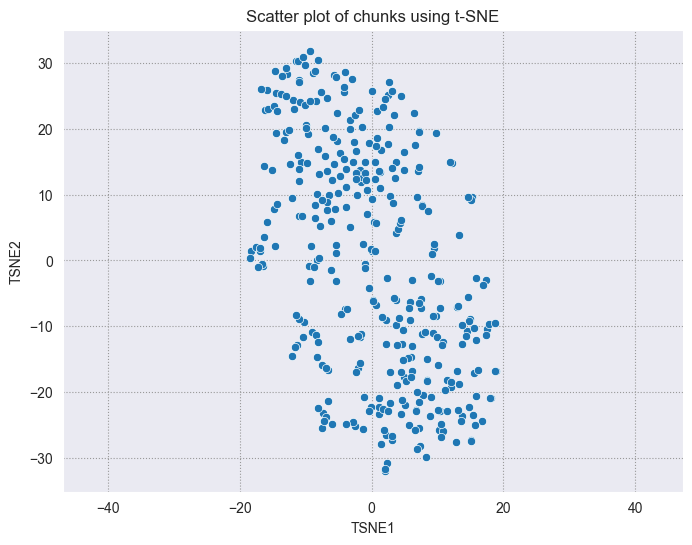

In [421]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2')
plt.title("Scatter plot of chunks using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

### Visualizing Chunks - Color Codeded By Similarity To Prompt

In [422]:
query_embed = np.array(textembed_model.get_embeddings([question])[0].values)
similarity = np.dot(query_embed, chunks_embed_db.T)
df_tsne['similarity'] = similarity.tolist()

(-20.304586029052736,
 20.68864212036133,
 -35.119011116027835,
 35.033771705627444)

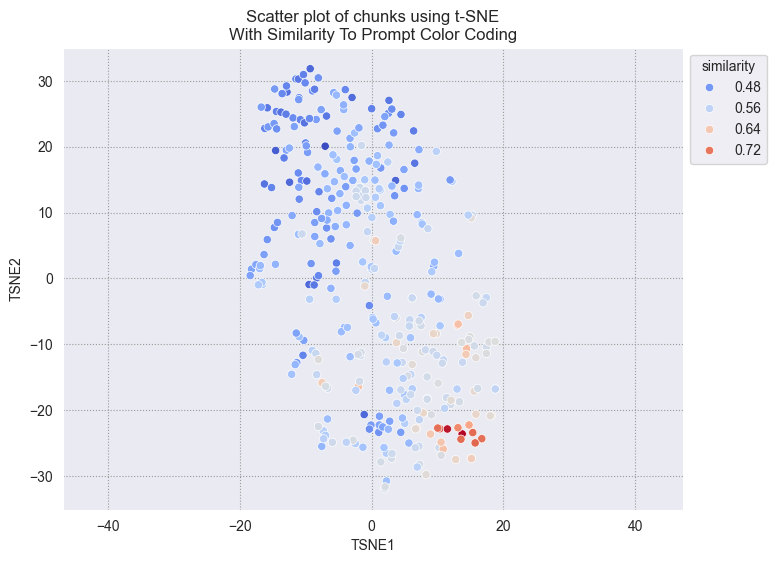

In [423]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2', hue = 'similarity', palette = sns.color_palette('coolwarm', as_cmap=True))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of chunks using t-SNE\nWith Similarity To Prompt Color Coding")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

### Visualizing Chunks - Call Out Matches

In [424]:
matches = chunk_match(question)

In [425]:
df_tsne.iloc[[match[0] for match in matches]]

,TSNE1,TSNE2,similarity
249,13.745081,-23.608088,0.783433
253,11.502452,-22.859053,0.776355
108,10.349723,-22.820206,0.743178
256,15.718754,-24.971420,0.731848
226,15.353017,-23.404743,0.729563
255,13.561147,-24.407183,0.727928
257,10.044410,-22.720789,0.726827


(-20.304586029052736,
 20.68864212036133,
 -35.119011116027835,
 35.033771705627444)

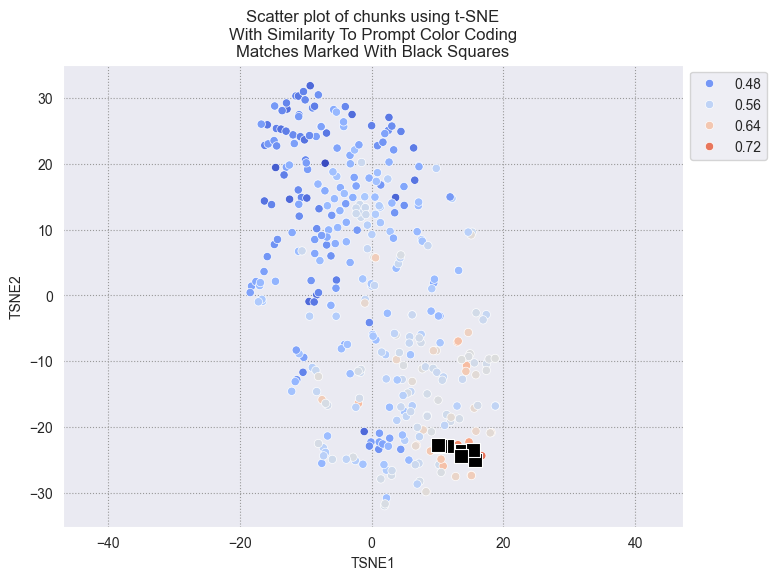

In [426]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2', hue = 'similarity', palette = sns.color_palette('coolwarm', as_cmap=True))
sns.scatterplot(data = df_tsne.iloc[[match[0] for match in matches]], x="TSNE1", y="TSNE2", color = 'black', marker = 's', s = 100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of chunks using t-SNE\nWith Similarity To Prompt Color Coding\nMatches Marked With Black Squares")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

---
## Review Structure of Objects: `files_pages`, `files_pages_elements`

In [427]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [428]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'entities', 'text_styles', 'entity_relations', 'text_changes', 'revisions', 'embedding', 'path', 'file', 'page', 'vme_id', 'dimensions'])

In [429]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [430]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

---
## Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Prepares and presents all the information back to the user

### Functions For Bot

#### Retrieval Functions

These retrieve context.

**NOTE**: `get_retrieval` calls `expand_retrieval` which call `get_retrieval`.  This can lead to infinate recursion but is prevent by `expand_retrieval` calling `get_retrieval` with `DISTANCE` left at default to prevent a further call to `expand_retrieval`.  Max recursion is 1 in this case. 

In [431]:
def get_chunks(query, k = -1, simk = -1):
    # k set the number of matches to retrieve, regarless of similarity. k = -1 will trigger calculating k dynamically.
    # simk sets a threshold for similarity: <=0 uses k, (0,1] will get all matches with similarity in range [1-simk, 1] 
    
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, chunks_embed_db.T) # for dot product, higher is better match, since normalized embeddings 1 is best, 0 is worst
    matches = np.argsort(similarity)[::-1].tolist()
    
    if k <= 0:
        # algorithm to dynamically pick k
        k = 1 + 3*int(10*(1-similarity[matches[0]]))
    if simk <= 0:
        matches = [(match, similarity[match]) for match in matches[0:k]]
    elif simk > 0 and simk <= 1:
        indicies = np.where(similarity >= 1-simk)[0]
        matches = [(i, similarity[i]) for i in indicies]
     
    return matches

def expand_retrieval(contexts, DISTANCE):
    
    additional_contexts = []
    if DISTANCE > 0:
        
        # for each page look for surrounding chunks, collect chunks
        chunk_indexes = []
        for context in contexts:
            # get matches for the page from contexts
            matches = get_retrieval(context[2], simk = DISTANCE, file_page = (context[3]['file_index'], context[3]['page_index']))
            for match in matches:
                if match[0] not in chunk_indexes and match[0] not in [c[0] for c in contexts]:
                    chunk_indexes += [match[0]]
                    additional_contexts.append(match)

    return additional_contexts

def get_retrieval(question, k = -1, simk = -1, DISTANCE = 0, file_page = None):

    if file_page: # this is from a call to this function by expand_retrieval
        matches = [match + (files_pages_chunks[match[0]]['text'], files_pages_chunks[match[0]]['metadata'], True) for match in get_chunks(question, k = k, simk = simk) if file_page == (files_pages_chunks[match[0]]['metadata']['file_index'], files_pages_chunks[match[0]]['metadata']['page_index'])]
    else: # this is from a call to this function by the main function: document_bot
        matches = [match + (files_pages_chunks[match[0]]['text'], files_pages_chunks[match[0]]['metadata'], False) for match in get_chunks(question, k = k, simk = simk)]
    
    if DISTANCE > 0:
        matches = matches + expand_retrieval(matches, DISTANCE)
    
    return matches

#### Augmentation Functions

This function prepares the prompt by also adding retrieved context = augmenting.

In [432]:
def get_augmented(question, contexts, ground):
    prompt = ''
    
    if ground:
        prompt += "Give a detailed answer to the question using only the information from the numbered contexts provided below."
        prompt += "\n\nContexts:\n"
        prompt += "\n".join([f'  * Context {c+1}: "{context[2]}"' for c, context in enumerate(contexts)])
        prompt += "\n\nQuestion: " + question
    else:
        prompt += "Question: " + question
        
    # add the trigger to the prompt.  In this case, also include the zero shot chain of thought prompt "think step by step".
    prompt += "\n\nAnswer the question and give and explanation. Think step by step."
    
    return prompt

#### Generation Functions

These functions interact with LLMs to create responses.

In [433]:
def generate_gemini(prompt, genconfigs, model):
    response = model.generate_content(
        prompt,
        generation_config = vertexai.generative_models.GenerationConfig(
            **genconfigs
            
        )
    )

    try:
        text = response.text
    except Exception:
        text = None

    counter = 0
    while not text:
        genconfigs['temperature'] = .5 - counter*.1
        response = model.generate_content(
            prompt,
            generation_config = vertexai.generative_models.GenerationConfig(
                **genconfigs

            )
        )
        try:
            text = response.text
        except Exception:
            text = None
            counter += 1

        if counter == 6:
            text = 'Please check the prompt, it appears the response is getting blocked.'
    
    return text

def generate_palm(prompt, genconfigs, model):
    response = model.predict(
        prompt,
        **genconfigs
    )
    
    return response.text

def get_generation(prompt, max_output_tokens, model):
    models = dict(GEMINI = gemini_text, PALM_BISON = text_model_b, PALM_BISION32k = text_model_b32, PALM_UNICORN = text_model_u)
    
    genconfigs = dict(max_output_tokens = max_output_tokens)
    
    if model == 'GEMINI':
        response = generate_gemini(prompt, genconfigs, models[model])
    else:
        response = generate_palm(prompt, genconfigs, models[model])
    
    return response

#### Presentation Functions

These prepare the response for presentation - and display the results.

In [434]:
# get a font to use for annotating the page images:
# get font for annotations: get fonts from fonts.google.com
font_source_url = "https://fonts.googleapis.com/css2?family=Roboto+Mono&display=swap"
font_source = requests.get(font_source_url).content.decode("utf-8")
start_url = font_source.find('url(')+4
end_url = font_source.find(')', start_url)
font_url = font_source[start_url:end_url]
font = PIL.ImageFont.truetype(io.BytesIO(requests.get(font_url).content), 35)

def get_presentation(question, contexts, DISTANCE, response, display_contexts, display_annotations):
    # repeat the question
    IPython.display.display(IPython.display.Markdown(f'**The Question:**\n\n{question}\n\n'))
    
    # show the answer
    IPython.display.display(IPython.display.Markdown(f'**The Response:**\n\n{response}\n\n'))
    
    if display_contexts:
    # display the contexts information: page, similarity, hyperlink
        context_pres = '**Sources:**\n\n'
        pages = []
        context_types = [c[4] for c in contexts]
        if DISTANCE > 0:
            context_pres += f'Note: The {len(contexts) - sum(context_types)} contexts were expanded to gather {sum(context_types)} additional chunks on pages with matches using a similarity distance of {DISTANCE}.\n'
        for context in contexts:
            page = next([d['parsing']['path'], d['parsing']['file'], d['parsing']['page'], d['file_index'], d['page_index']] for d in files_pages if d['file_index'] == context[3]['file_index'] and d['page_index'] == context[3]['page_index'])
            pages.append(page)
            if not context[4]:
                context_pres += f'1. {page[0]}{page[1]}#page={page[2]}\n\t* page: {page[2]}, similarity to question is {context[1]:.3f}\n'
            # the following is commented out, if uncommented it would also add the expanded contexts to printed list (this can be very long for DISTANCE = 1 which is the full page)
            #else:
            #    context_pres += f'1. {page[0]}{page[1]}#page={page[2]}\n\t* page: {page[2]}, similarity to primary context is {context[1]:.3f}\n'
        IPython.display.display(IPython.display.Markdown(context_pres))
        
    if display_annotations:
    # display each page with annotations
        IPython.display.display(IPython.display.Markdown('**Annotated Document Pages**\n\n'))
        # list of unique pages across contexts: sorted list of tuple(file_index, page_index)
        pages = sorted(list(set([(page[3], page[4]) for page in pages])), key = lambda x: (x[0], x[1]))
        # list of PIL images for each unique page
        images = []
        for page in pages:
            image = next(d['parsing']['pages'][0]['image']['content'] for d in files_pages if d['file_index'] == page[0] and d['page_index'] == page[1])
            images.append(
                PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(
                            image.encode('utf-8')
                        )
                    )
                )
            )
        # annotate the contexts on the pages:
        for c, context in enumerate(contexts):
            image = images[pages.index((context[3]['file_index'], context[3]['page_index']))]
            vertices = context[3]['vertices']
            draw = PIL.ImageDraw.Draw(image)
            if not context[4]: 
                color = 'green'
                prefix = 'Source'
            else:
                color = 'blue'
                prefix = 'Expanded Source'
            draw.polygon([
                vertices[0]['x'], vertices[0]['y'],
                vertices[1]['x'], vertices[1]['y'],
                vertices[2]['x'], vertices[2]['y'],
                vertices[3]['x'], vertices[3]['y']
            ], outline = color, width = 5)
            draw.text(
                xy = (vertices[1]['x'], vertices[1]['y']), text = f"{prefix} {c+1}", fill = color, anchor = 'rd', font = font
            )
        
        for image in images:
            IPython.display.display(image.resize(tuple([int(.25*x) for x in image.size])))
            
    return

In [435]:
def document_bot(question, max_output_tokens = 1000, DISTANCE = 0, MODEL = 'GEMINI', display_contexts = False, display_annotations = False, ground = True):
    # this function directly references (without input): font
    # DISTANCE = .1 # float in [0, 1], 0 return no additional context, 1 return all on unique pages
    # MODEL = 'GEMINI' # one of: GEMINI, PALM_BISON, PALM_BISON32K, PALM_UNICORN
    
    # R: Retrival
    if ground:
        contexts = get_retrieval(question, DISTANCE = DISTANCE)
    else:
        contexts = []
        
    # A: Augemented
    prompt = get_augmented(question, contexts, ground)
    
    # G: Generation
    response = get_generation(prompt, max_output_tokens, MODEL)
    
    # Present Answer
    get_presentation(question, contexts, DISTANCE, response, display_contexts, display_annotations)
    
    return prompt

### Try Out Document_Bot:

#### The Question

In [436]:
question

'How 401(k) Matching Works?'

#### Get Ungrounded Response

In [437]:
prompt = document_bot(question, ground = False)

**The Question:**

How 401(k) Matching Works?



**The Response:**

**How 401(k) Matching Works**

401(k) matching is a contribution your employer makes to your retirement account when you contribute a certain amount. This can be a great way to boost your savings and reduce your taxes. Here's how it works:

1. **Eligibility:** You must be enrolled in your employer's 401(k) plan to be eligible for matching contributions.

2. **Matching Formula:** Your employer will typically have a matching formula, which determines how much they will contribute. For example, they may offer to match up to 50% of the first 6% of your salary that you contribute to the plan.

3. **Contribution Limits:** There are limits to how much your employer can match. In 2023, the limit is 100% of your salary, up to $66,000 (or $73,500 if you're age 50 or older).

4. **Employer Contributions:** When you make an eligible contribution to your 401(k), your employer will make a matching contribution to your account. The matching contribution is typically made in the form of company stock or a cash equivalent.

5. **Vesting:** Matching contributions may be subject to vesting. This means you may not have immediate access to the full amount. The vesting period typically depends on how long you remain employed with the company.

**Example**

Let's say you earn a salary of $50,000 and your employer offers to match up to 50% of the first 6% of your salary. If you contribute $3,000 to your 401(k), your employer will contribute an additional $1,500 (50% of the first $3,000).

**Benefits of 401(k) Matching**

* **Tax Savings:** Employer contributions to your 401(k) are typically made pre-tax, which means they are not subject to current federal income taxes.
* **Boosted Savings:** 401(k) matching can help you save more for retirement, especially if you take advantage of the full match.
* **Employer Contribution:** The matching contributions are essentially free money from your employer that can help you grow your retirement savings faster.



#### Get Grounded Response

In [438]:
prompt = document_bot(question)

**The Question:**

How 401(k) Matching Works?



**The Response:**

**Step 1: Understand Vesting**

Vesting refers to when you own the rights to money in your 401(k) account. You are always 100% vested in your personal contributions, but you vest in matching contributions gradually over time. After two years of service, you vest 20% in matching contributions, and then an additional 20% for every subsequent year of service. You are 100% vested in matching contributions after six years. (Context 6)

**Step 2: HCA Healthcare's Matching Contribution**

HCA Healthcare offers a 100% match on your 401(k) Plan contributions, up to 9% of pay based on years of service. (Context 7)

**Step 3: How Matching Works**

For every $1 you contribute to your 401(k) Plan, HCA Healthcare will contribute $1, up to your matching level. The matching level depends on your years of service:

* 0-4 years: 100% of 3% of pay
* 5-9 years: 100% of 4% of pay
* 10-14 years: 100% of 6% of pay
* 15-19 years: 100% of 7% of pay
* 20-24 years: 100% of 8% of pay
* 25+ years: 100% of 9% of pay (Context 1)

**Example:**

Let's say you have been with HCA Healthcare for 10 years and you contribute 5% of your pay to your 401(k) Plan. HCA Healthcare will match 100% of your contribution, up to 6% of your pay. So, if your pay is $50,000, HCA Healthcare will contribute $3,000 to your 401(k) Plan.



#### Get Grounded Response, Print Out Contexts

In [439]:
prompt = document_bot(question, display_contexts = True)

**The Question:**

How 401(k) Matching Works?



**The Response:**

**Step 1: Understand the concept of 401(k) matching.**

401(k) matching is a type of employer-sponsored retirement contribution where the employer contributes a certain amount of money to the employee's 401(k) account based on the employee's own contributions.

**Step 2: Determine the vesting period.**

Vesting refers to the period of time an employee must work for a company before they own the matching contributions made by the employer. 

**Step 3: Calculate the matching contribution.**

The matching contribution is calculated as a percentage of the employee's own contributions. The percentage varies depending on the years of service.

**Step 4: Example.**

For example, if an employee has been with the company for 5-9 years, the employer will contribute 100% of 4% of the employee's pay. So, if the employee contributes $100 to their 401(k), the employer will contribute an additional $40.



**Sources:**

1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.783
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.776
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=3
	* page: 3, similarity to question is 0.743
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.732
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=8
	* page: 8, similarity to question is 0.730
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.728
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.727


#### Get Grounded Response, Print Out Contexts And Annotated Pages

**The Question:**

How 401(k) Matching Works?



**The Response:**

1. Your employer (HCA Healthcare) will contribute an amount of money (the match) to your 401(k) account for every dollar you contribute. (Context 2)
2. The percentage of your pay that you contribute determines the percentage of your pay that your employer will match. (Context 1)
3. To be eligible for the annual match, you must receive pay for at least 1,000 hours of service during the plan year. (Context 2)
4. You are always 100% vested in your personal contributions. (Context 6)
5. You vest 20% in matching contributions after two years of service. (Context 6)
6. You vest an additional 20% for every subsequent year of service. (Context 6)
7. You are 100% vested in matching contributions after six years. (Context 6)



**Sources:**

1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.783
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.776
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=3
	* page: 3, similarity to question is 0.743
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.732
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=8
	* page: 8, similarity to question is 0.730
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.728
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.727


**Annotated Document Pages**



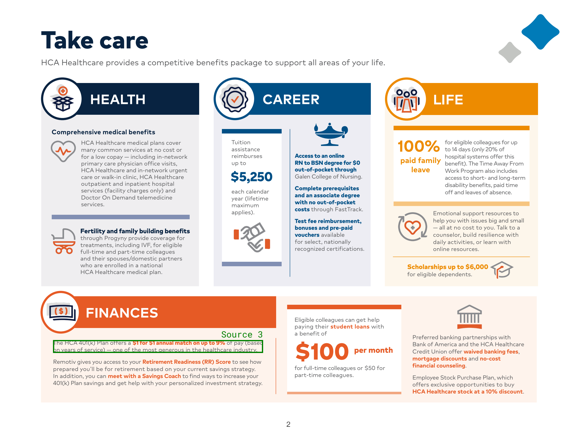

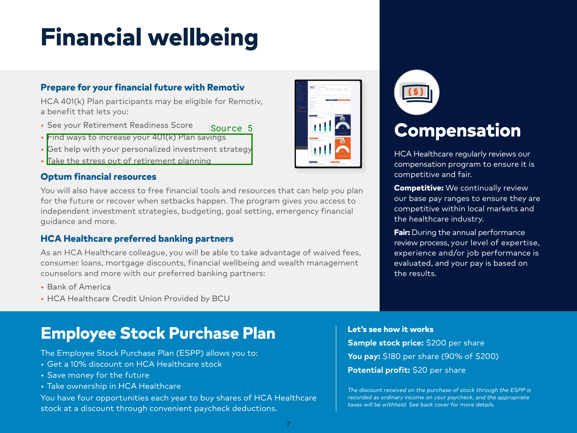

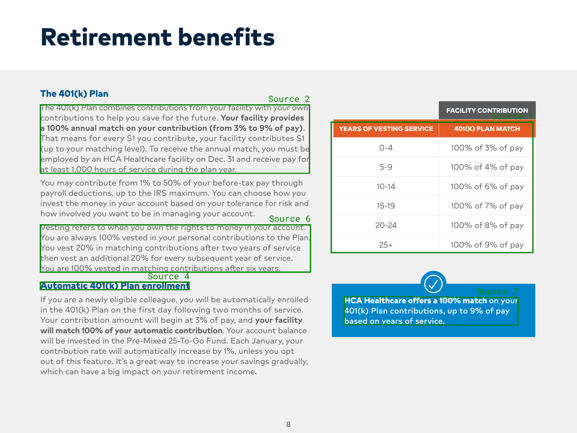

In [440]:
prompt = document_bot(question, display_contexts = True, display_annotations = True)

#### Get Grounded Response With Expanded Contexts, Print Out Contexts And Annotated Pages

**The Question:**

How 401(k) Matching Works?



**The Response:**

**Step 1: Facility Contribution**

The facility (employer) contributes a certain percentage of your pay to your 401(k) account, based on your years of vesting service. The percentage starts at 3% for the first 4 years of service and increases to 9% for 25+ years of service.

**Step 2: Vesting**

Vesting refers to the period of time you must work for the employer to gain ownership of the matching contributions. You are always 100% vested in your own contributions. You vest 20% in matching contributions after two years of service, and an additional 20% for each subsequent year of service. You are 100% vested in matching contributions after six years.

**Step 3: Annual Match**

To receive the annual match, you must be employed by HCA Healthcare on December 31 and receive pay for at least 1,000 hours of service during the plan year.

**Example:**

If you have been employed for 10 years and contribute 6% of your pay to your 401(k), your facility will contribute an additional 6% of your pay to your account. If you contribute $1,000 to your account, your facility will contribute an additional $1,000.



**Sources:**

Note: The 7 contexts were expanded to gather 77 additional chunks on pages with matches using a similarity distance of 1.
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.783
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.776
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=3
	* page: 3, similarity to question is 0.743
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.732
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=8
	* page: 8, similarity to question is 0.730
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.728
1. https://careers.hcahealthcare.com/system/production/assets/421507/original/2024_HCA_Healthcare_Benefits_Brochure.pdf#page=9
	* page: 9, similarity to question is 0.727


**Annotated Document Pages**



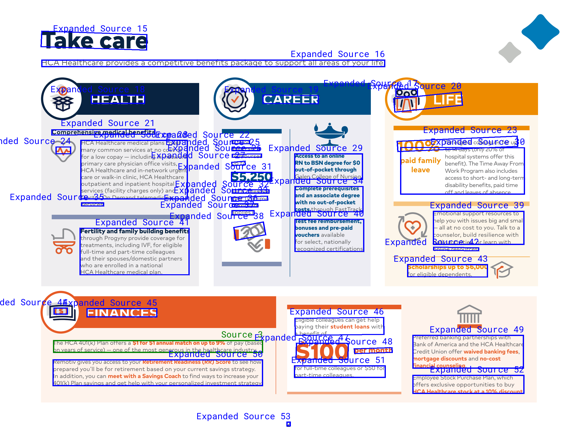

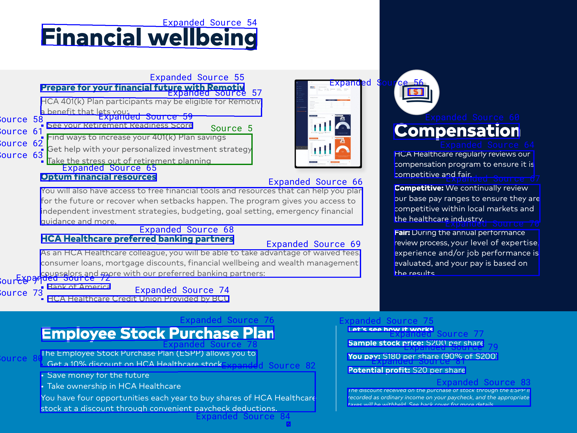

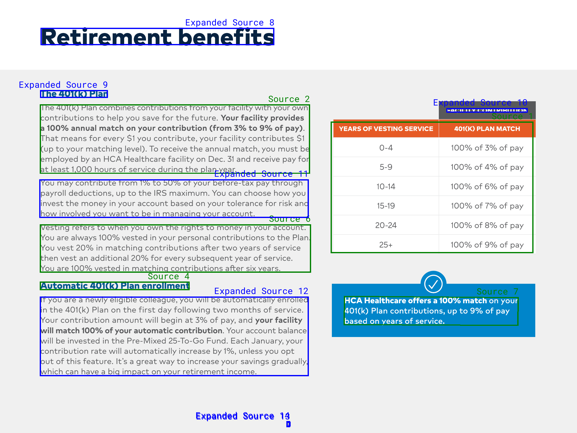

In [441]:
prompt = document_bot(question, DISTANCE = 1, display_contexts = True, display_annotations = True)

#### Get Grounded Response From Out Of Context Questions

Even though the question is on topic for the documents, baseball, it is about specific players and teams which is out of context of the indexed documents which are about the rules of the game of baseball.

In [442]:
prompt = document_bot('Who is the best pitcher for the Dodgers?')

ServiceUnavailable: 503 502:Bad Gateway

### Harder Questions

In [ ]:
prompt = document_bot("What is the definition of a balk?", DISTANCE = 0.5)

In [ ]:
prompt = document_bot("Is a rule broken if three infielders are positioned on the same side of the field where the batter is more likely to hit the ball?", DISTANCE = 0.5)

In [ ]:
prompt = document_bot("A batter hits a fair ball that goes over the outfield fence. Is this always a home run?",display_contexts = True, display_annotations = True)

In [ ]:
prompt = document_bot("Describe the shape of bases.",display_contexts = True, display_annotations = True)

---
## Next Steps!

While the document bots performs well and the configuation of `DISTANCE` allows users to gather expanded contexts, it still can be improved.

These enhancements will follow in additional notebooks:
- Enhanced context retrieval with a tree of contexts
    - This will provided a much better context for general questions that infer information from a broad section of the document. Like "How do I play baseball?"
- Multi-modal prompts
    - By included images from documents in the context retrieval and the prompt the context can also be inferred from the images.  This will help with the question about bases where the primary description in the rules is a graphic with dimensions.